In [1]:
# import python libraries
import pandas as pd
import numpy as np

# import visualization tools
from matplotlib.pyplot import show
from sklearn.tree import plot_tree

#import created functions
from prepare import prep_data
from model import baseline_model, tree_model, forest_model, knn_model, logit_model, validate, final_test
from measure import model_report

# cosmetic imports and settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from explore import end


---
# Begin Modeling Phase

In the exploration notebook, we explored through the `train` dataset that will be used to create our machine learning predictive models. We discovered correlations between the `fiber`, `monthly_charges`, `tenure`, and `no_contract` variables as the related to `churn`. These will be our features along with the associated `has_internet` variable. Let's assign them to a variable now for our data fetching functions. Then we will use our `prep_data` function to obtain the prepared DataFrames we will need for model creation.

---

In [2]:
# create list of features to pass into function for DataFrame column creation
features = ['has_internet', 'fiber', 'monthly_charges', 'no_contract', 'tenure']


In [3]:
# obtain prepped DataFrames for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = prep_data(columns=features)


In [4]:
# inspect X_train head to ensure appropriate features
X_train.head(3).T


,1366,5547,3961
has_internet,1.00,0.00,1.00
fiber,0.00,0.00,1.00
monthly_charges,45.85,20.10,100.15
no_contract,1.00,0.00,1.00
tenure,2.00,57.00,8.00


### Baseline Creation

Now that we've prepped our data, we can create a baseline of churn prediction using the most common class.

In [5]:
y_train.value_counts()


0    3104
1    1121
Name: churn, dtype: int64

We see that for our churn target, the most common class is not churned, `0`. We will assign this as our baseline prediction using `DummyClassifier` with `strategy='most_frequent'` to automatically populate with the most common class.

In [6]:
# use baseline_model function from model module to create baseline
# and print output and performance
baseline, _ = baseline_model(X_train, y_train)



               Baseline Accuracy Score: 73.47%
        First Ten Baseline Predictions: [0 0 0 0 0 0 0 0 0 0]
        


Using our `baseline_model` function, we can create a baseline using our above described tools and get a print out of the accuracy score and first ten values.

As we can see, all of our values within match with our previous findings of `0` being the most common class. Our baseline is completed, now it's time to move on to creating our own classification models.


---
# Model Creation

To begin creating our predictive models, we need to first decide which kind of models to create. We can choose between the typical classifcation models of Decision Trees, Random Forests, K-Nearest Neighbors, or Logistic Regression. We will start with simpler models and adjust our features and hyperparamters as needed.

---

### Decision Tree

First attempt at a predictive model, we will make a basic decision tree using `sklearn.tree.DecisionTreeClassifier` standard hyperparameters.

In [7]:
# use tree_model function to create model using all default 
# hyperparameters and random_state=19, output model and predictions
tree, tree_pred = tree_model(X_train, y_train)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   98.49%          |
|       True Positive Rate:   82.81%          |
|      False Positive Rate:   25.67%          |
|       True Negative Rate:   74.33%          |
|      False Negative Rate:   17.19%          |
|                Precision:   98.98%          |
|                   Recall:   95.27%          |
|                 F1-Score:   97.09%          |
|                                             |
|         Positive Support:     1121          |
|         Negative Support:     3104          |
|            Total Support:     4225          |
|_____________________________________________|



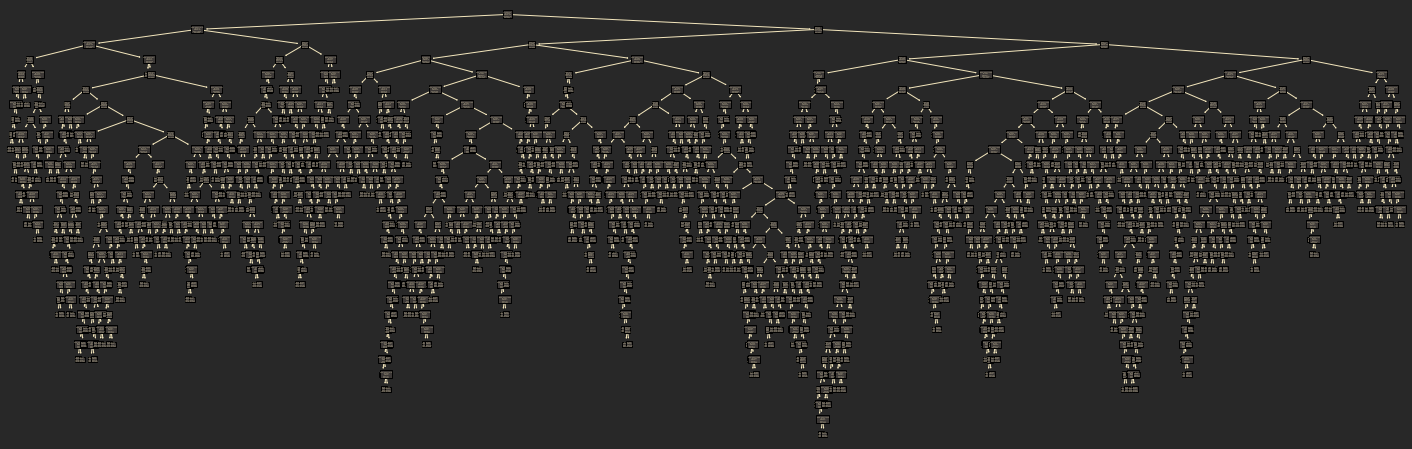

In [8]:
# visualize the tree using sklearn plot_tree
plot_tree(tree, feature_names=features, class_names=['retain', 'churn'])
show()


Holy moly, that sure is something. Without proceeding any further, we can tell this model is going to be overfit to the training data. As nice as it would be to believe in that 98% accuracy, there is no way this holds up in the validation or testing phase. Time for some landscaping!

Let's change some hyperparameters by limiting the growth of our tree to only a few levels. This should minimize overfitting on the training model.

In [9]:
# limit tree growth to three levels
tree, tree_pred = tree_model(X_train, y_train, max_depth=3)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   79.38%          |
|       True Positive Rate:   76.58%          |
|      False Positive Rate:   13.54%          |
|       True Negative Rate:   86.46%          |
|      False Negative Rate:   23.42%          |
|                Precision:   69.00%          |
|                   Recall:   40.50%          |
|                 F1-Score:   51.04%          |
|                                             |
|         Positive Support:     1121          |
|         Negative Support:     3104          |
|            Total Support:     4225          |
|_____________________________________________|



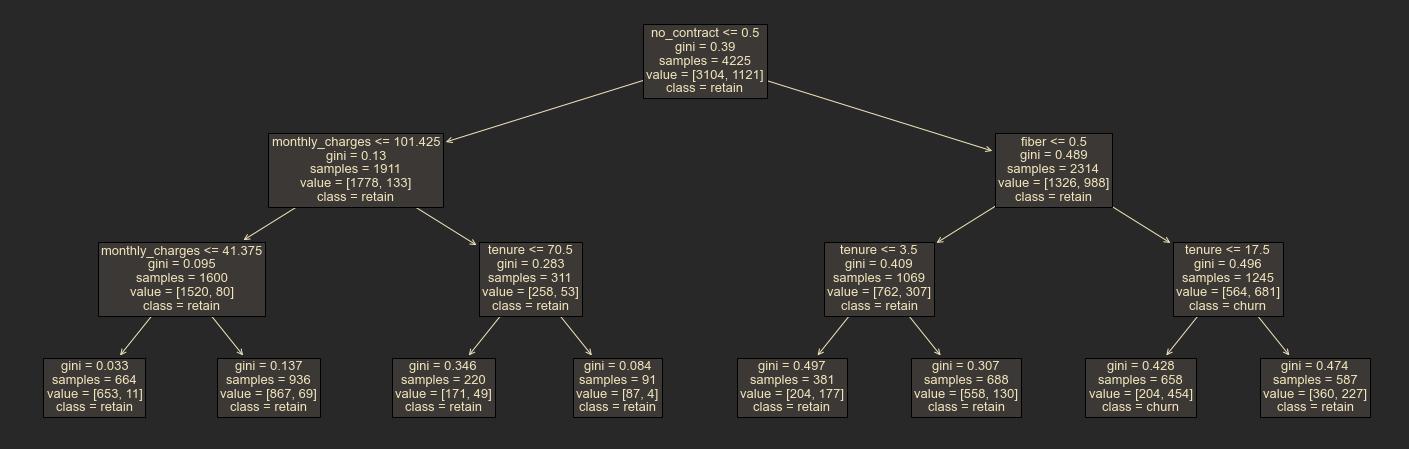

In [10]:
# visualize new tree model
plot_tree(tree, feature_names=features, class_names=['retain', 'churn'])
show()


Not as impressive at first look, but this smaller tree's accuracy on training still beats our baseline by several percentage points. What's more, it should be much closer to the performance we will see on our evaluation dataset.

### Random Forest

Let's not miss the forest for the trees. Next up we will make use of `sklearn.tree.RandomForestClassifier`, again using all default hyperparameters.

In [11]:
# use forest_model function to create model using all default 
# hyperparameters and random_state=19, output model and predictions
forest, forest_pred = forest_model(X_train, y_train)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   98.46%          |
|       True Positive Rate:   50.77%          |
|      False Positive Rate:   26.15%          |
|       True Negative Rate:   73.85%          |
|      False Negative Rate:   49.23%          |
|                Precision:   97.14%          |
|                   Recall:   97.06%          |
|                 F1-Score:   97.10%          |
|                                             |
|         Positive Support:     1121          |
|         Negative Support:     3104          |
|            Total Support:     4225          |
|_____________________________________________|



Once again we see that high accuracy score. Since this model is just $n$ trees in the forest, we know this is going to overfit the training data once again. This time we are going to need a lumberjack instead of some shears!

Just like before, we can change some simple hyperparamters to prevent overgrowth of our trees.

In [12]:
# limit growth to 3 levels, 10 max leaf nodes
forest, forest_pred = forest_model(X_train, y_train, max_depth=3, max_leaf_nodes=10)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   79.38%          |
|       True Positive Rate:   76.58%          |
|      False Positive Rate:   13.54%          |
|       True Negative Rate:   86.46%          |
|      False Negative Rate:   23.42%          |
|                Precision:   69.00%          |
|                   Recall:   40.50%          |
|                 F1-Score:   51.04%          |
|                                             |
|         Positive Support:     1121          |
|         Negative Support:     3104          |
|            Total Support:     4225          |
|_____________________________________________|



Just like before, we see this lower accuracy on the refit model. This is the cost to prevent overfitting of the model. This model also exceeds our baseline  similar to the tree model.

### K-Nearest Neighbor

With KNN models, we don't have to worry about model overgrowth causing substantial overfit like with trees and forests. Let's just use the default hyperparamters.

In [13]:
knn, knn_pred = knn_model(X_train, y_train)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   84.19%          |
|       True Positive Rate:   62.57%          |
|      False Positive Rate:   19.76%          |
|       True Negative Rate:   80.24%          |
|      False Negative Rate:   37.43%          |
|                Precision:   73.77%          |
|                   Recall:   62.71%          |
|                 F1-Score:   67.79%          |
|                                             |
|         Positive Support:     1121          |
|         Negative Support:     3104          |
|            Total Support:     4225          |
|_____________________________________________|



This is already pretty strong without too much manipulation of the hyperparameters. We'll leave this here, hoping the model isn't overfit to the dataset.

### Logistic Regression

Here we will create a Logistic Regression model, also known as logit, using only default hyperparamters once again.

In [14]:
logit, logit_pred = logit_model(X_train, y_train)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   78.98%          |
|       True Positive Rate:   66.10%          |
|      False Positive Rate:   16.00%          |
|       True Negative Rate:   84.00%          |
|      False Negative Rate:   33.90%          |
|                Precision:   63.95%          |
|                   Recall:   47.64%          |
|                 F1-Score:   54.60%          |
|                                             |
|         Positive Support:     1121          |
|         Negative Support:     3104          |
|            Total Support:     4225          |
|_____________________________________________|



This one performs fairly well in overall accuracy, but it does even better at predicting the negative class.

We have some models; now it's time to see how our models perform on out-of-sample data and evaluate them for our target!

---
## Model Evaluation

Now that we have created a few models, let's see how they perform on the out-of-sample data, the `validate` dataset. Since a false positive would be less detrimental to the company than a false negative, we are going to be optimizing for higher recall of the positive class.

---

#### Decision Tree


In [15]:
tree_val_pred = validate(X_validate, y_validate, tree)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   79.19%          |
|       True Positive Rate:   75.45%          |
|      False Positive Rate:   13.74%          |
|       True Negative Rate:   86.26%          |
|      False Negative Rate:   24.55%          |
|                Precision:   68.05%          |
|                   Recall:   40.93%          |
|                 F1-Score:   51.11%          |
|                                             |
|         Positive Support:      281          |
|         Negative Support:      776          |
|            Total Support:     1057          |
|_____________________________________________|



As we said in the previous section, we are going to be using a model that optimizes for recall of the positive class to maximize catching churn. We see an overall accuracy of $\approx79\%$ and a recall of only $\approx41\%$. This does not seem likely a good candidate for our purposes.

#### Random Forest

In [16]:
forest_val_pred = validate(X_validate, y_validate, forest)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   79.19%          |
|       True Positive Rate:   75.45%          |
|      False Positive Rate:   13.74%          |
|       True Negative Rate:   86.26%          |
|      False Negative Rate:   24.55%          |
|                Precision:   68.05%          |
|                   Recall:   40.93%          |
|                 F1-Score:   51.11%          |
|                                             |
|         Positive Support:      281          |
|         Negative Support:      776          |
|            Total Support:     1057          |
|_____________________________________________|



Much like with our decision tree, we have comparable numbers with this model. It seems all the trees in the forest think alike. Low recall means low capture of out target.

#### K-Nearest Neighbor

In [17]:
knn_val_pred = validate(X_validate, y_validate, knn)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   76.73%          |
|       True Positive Rate:   58.54%          |
|      False Positive Rate:   16.89%          |
|       True Negative Rate:   83.11%          |
|      False Negative Rate:   41.46%          |
|                Precision:   57.32%          |
|                   Recall:   48.75%          |
|                 F1-Score:   52.69%          |
|                                             |
|         Positive Support:      281          |
|         Negative Support:      776          |
|            Total Support:     1057          |
|_____________________________________________|



There is definite improvement in this model with regard to our desired purpose. We have a lower overall accuracy, but increased recall by several percentage points.

#### Logical Regression

In [18]:
logit_val_pred = validate(X_validate, y_validate, logit)



            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   79.09%          |
|       True Positive Rate:   64.25%          |
|      False Positive Rate:   16.63%          |
|       True Negative Rate:   83.37%          |
|      False Negative Rate:   35.75%          |
|                Precision:   63.76%          |
|                   Recall:   49.47%          |
|                 F1-Score:   55.71%          |
|                                             |
|         Positive Support:      281          |
|         Negative Support:      776          |
|            Total Support:     1057          |
|_____________________________________________|



And lastly, this seems like the most likely candidate of our created models. Still has an accuracy above our baseline, and this model has the best capture of the positive case of churn. This will be our model for the testing phase.

## Summation

In our modeling notebook, we create four models for predicting churn in the telco_churn data. We have explored; we have created; we have evaluated. It's time for a few key takeaways.

- We know our features had the strongest correlations with our target of churn from exploration
- Our baseline prediction was $\approx73\%$, and all of our models bested it in training
- In creating our models, trying to optimize for recall, we were unable to surpass 50%

This concludes modeling, it's now time for our final report.

In [19]:
end()












































































































See You Space Cowboy...
